In [1]:
import tensorflow 

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [2]:
print("Tensorflow-version:", tensorflow.__version__)

Tensorflow-version: 2.5.0


In [3]:
base_model=DenseNet121(weights='imagenet',include_top=False, input_shape=(128, 128, 3)) 

x=base_model.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(5,activation='softmax')(x) #FC-layer

In [4]:
model=Model(inputs=base_model.input,outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [5]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True
    

In [6]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [7]:
import nibabel as nib
import skimage.transform as skTrans


data=[]
labels=[]
random.seed(42)
imagePaths = sorted(list(os.listdir("studies/data/")))
random.shuffle(imagePaths)
print(imagePaths)

for img in imagePaths:
    path=sorted(list(os.listdir("studies/data/"+img)))
    for i in path:
        img_path = "studies/data/"+str(img)+'/'+str(i)
        image = nib.load(img_path)
        image_d = image.get_fdata()
        queue = image.dataobj.shape[2]
        img_arr = skTrans.resize(image_d, (128, 128, queue), order=1, preserve_range=True)
        img_arrs = img_arr[:,:,queue//2-3:queue//2]
        data.append(img_arrs)
        l = label = img
        labels.append(l[-1])
        
        
#data=[]
#imagePaths = sorted(list(os.listdir("studies/data/")))
#print(imagePaths)
#for img in imagePaths:
 #   path=sorted(list(os.listdir("studies/data/"+img)))
  #  for i in path:
   #     img_path = "studies/data/"+str(img)+'/'+str(i)
    #    image = nib.load(img_path)
     #   image_d = image.get_fdata()
      #  queue = image.dataobj.shape[2]
       # img_arr = skTrans.resize(image_d, (128, 128, queue), order=1, preserve_range=True)
        #img_arrs = img_arr[:,:,queue//2-3:queue//2]
        #data.append((img_arrs, int(img[-1])))
        
        
    
    #for i in path:
        #image_path = "studies/data/"+str(img)+'/'+str(i)
        #print(image_path)
        #image = nib.load(image_path)
        #queue = image.dataobj.shape[2]
        #for i in range(0, queue, 10):
         #   img_arr = image.dataobj[:,:,i-3:i]
          #  img_arr = cv2.resize(img_arr, output_shape=(128, 128, 3), preserve_range=True)
            #:, :, i-3:i
        #data.append((img_arr, int(img[-1])))
                                  
        #image = cv2.resize(image, (128,128))
        #image = img_to_array(image)
        #data.append(image)
        #l = label = img
        #labels.append(l)

['CT-3', 'CT-1', 'CT-2', 'CT-4', 'CT-0']


In [8]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
print(labels[0])

[0 0 0 1 0]


In [9]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.4,random_state=42)
print(xtrain.shape, xtest.shape)

(657, 128, 128, 3) (438, 128, 128, 3)


In [10]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(xtrain)
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=128),
            steps_per_epoch=xtrain.shape[0] //128,
            epochs=300,
            verbose=2,
            callbacks=[anne, checkpoint],
            validation_data=(xtrain, ytrain))

#history = model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=20, batch_size=16, 
#callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)])
  

Epoch 1/300
5/5 - 35s - loss: 2.7484 - accuracy: 0.2250 - val_loss: 2.2956 - val_accuracy: 0.1263

Epoch 00001: val_loss improved from inf to 2.29559, saving model to model.h5
Epoch 2/300
5/5 - 8s - loss: 2.5242 - accuracy: 0.2969 - val_loss: 2.4988 - val_accuracy: 0.1811

Epoch 00002: val_loss did not improve from 2.29559
Epoch 3/300
5/5 - 8s - loss: 2.3104 - accuracy: 0.3270 - val_loss: 3.1209 - val_accuracy: 0.2420

Epoch 00003: val_loss did not improve from 2.29559
Epoch 4/300
5/5 - 8s - loss: 2.0473 - accuracy: 0.3686 - val_loss: 3.4069 - val_accuracy: 0.2374

Epoch 00004: val_loss did not improve from 2.29559
Epoch 5/300
5/5 - 9s - loss: 2.0007 - accuracy: 0.3766 - val_loss: 3.3602 - val_accuracy: 0.2359

Epoch 00005: val_loss did not improve from 2.29559
Epoch 6/300
5/5 - 8s - loss: 1.8158 - accuracy: 0.4064 - val_loss: 2.5929 - val_accuracy: 0.2374

Epoch 00006: val_loss did not improve from 2.29559
Epoch 7/300
5/5 - 9s - loss: 1.7698 - accuracy: 0.4045 - val_loss: 1.9859 - val

5/5 - 9s - loss: 0.8727 - accuracy: 0.6446 - val_loss: 0.6928 - val_accuracy: 0.7123

Epoch 00051: val_loss improved from 0.69826 to 0.69279, saving model to model.h5
Epoch 52/300
5/5 - 9s - loss: 0.8743 - accuracy: 0.6219 - val_loss: 0.7015 - val_accuracy: 0.7017

Epoch 00052: val_loss did not improve from 0.69279
Epoch 53/300
5/5 - 9s - loss: 0.9127 - accuracy: 0.6238 - val_loss: 0.7056 - val_accuracy: 0.6986

Epoch 00053: val_loss did not improve from 0.69279
Epoch 54/300
5/5 - 9s - loss: 0.9325 - accuracy: 0.5938 - val_loss: 0.6859 - val_accuracy: 0.6971

Epoch 00054: val_loss improved from 0.69279 to 0.68589, saving model to model.h5
Epoch 55/300
5/5 - 9s - loss: 0.8816 - accuracy: 0.6276 - val_loss: 0.7031 - val_accuracy: 0.6941

Epoch 00055: val_loss did not improve from 0.68589
Epoch 56/300
5/5 - 9s - loss: 0.8858 - accuracy: 0.6578 - val_loss: 0.7048 - val_accuracy: 0.7017

Epoch 00056: val_loss did not improve from 0.68589
Epoch 57/300
5/5 - 9s - loss: 0.8717 - accuracy: 0.62

5/5 - 9s - loss: 0.7796 - accuracy: 0.6786 - val_loss: 0.5327 - val_accuracy: 0.7732

Epoch 00102: val_loss did not improve from 0.53107
Epoch 103/300
5/5 - 11s - loss: 0.6972 - accuracy: 0.6953 - val_loss: 0.5400 - val_accuracy: 0.7656

Epoch 00103: val_loss did not improve from 0.53107
Epoch 104/300
5/5 - 9s - loss: 0.7070 - accuracy: 0.6767 - val_loss: 0.5324 - val_accuracy: 0.7960

Epoch 00104: val_loss did not improve from 0.53107
Epoch 105/300
5/5 - 9s - loss: 0.6740 - accuracy: 0.7108 - val_loss: 0.5304 - val_accuracy: 0.7884

Epoch 00105: val_loss improved from 0.53107 to 0.53039, saving model to model.h5
Epoch 106/300
5/5 - 9s - loss: 0.6851 - accuracy: 0.7089 - val_loss: 0.5119 - val_accuracy: 0.7884

Epoch 00106: val_loss improved from 0.53039 to 0.51185, saving model to model.h5
Epoch 107/300
5/5 - 9s - loss: 0.7288 - accuracy: 0.6824 - val_loss: 0.5078 - val_accuracy: 0.7930

Epoch 00107: val_loss improved from 0.51185 to 0.50777, saving model to model.h5
Epoch 108/300
5/5

5/5 - 9s - loss: 0.6708 - accuracy: 0.7183 - val_loss: 0.4150 - val_accuracy: 0.8554

Epoch 00153: val_loss did not improve from 0.39884
Epoch 154/300
5/5 - 8s - loss: 0.6505 - accuracy: 0.7089 - val_loss: 0.4146 - val_accuracy: 0.8463

Epoch 00154: val_loss did not improve from 0.39884
Epoch 155/300
5/5 - 9s - loss: 0.6557 - accuracy: 0.7221 - val_loss: 0.4123 - val_accuracy: 0.8387

Epoch 00155: val_loss did not improve from 0.39884
Epoch 156/300
5/5 - 9s - loss: 0.6162 - accuracy: 0.7344 - val_loss: 0.4215 - val_accuracy: 0.8265

Epoch 00156: val_loss did not improve from 0.39884
Epoch 157/300
5/5 - 9s - loss: 0.6214 - accuracy: 0.7505 - val_loss: 0.4186 - val_accuracy: 0.8250

Epoch 00157: val_loss did not improve from 0.39884
Epoch 158/300
5/5 - 9s - loss: 0.6500 - accuracy: 0.7240 - val_loss: 0.4078 - val_accuracy: 0.8417

Epoch 00158: val_loss did not improve from 0.39884
Epoch 159/300
5/5 - 9s - loss: 0.6301 - accuracy: 0.7543 - val_loss: 0.4051 - val_accuracy: 0.8447

Epoch 00

5/5 - 9s - loss: 0.6346 - accuracy: 0.7353 - val_loss: 0.3379 - val_accuracy: 0.8752

Epoch 00205: val_loss improved from 0.33832 to 0.33789, saving model to model.h5
Epoch 206/300
5/5 - 9s - loss: 0.5646 - accuracy: 0.7734 - val_loss: 0.3261 - val_accuracy: 0.8843

Epoch 00206: val_loss improved from 0.33789 to 0.32613, saving model to model.h5
Epoch 207/300
5/5 - 9s - loss: 0.5481 - accuracy: 0.7864 - val_loss: 0.3268 - val_accuracy: 0.8721

Epoch 00207: val_loss did not improve from 0.32613
Epoch 208/300
5/5 - 9s - loss: 0.5399 - accuracy: 0.7694 - val_loss: 0.3290 - val_accuracy: 0.8661

Epoch 00208: val_loss did not improve from 0.32613
Epoch 209/300
5/5 - 9s - loss: 0.5161 - accuracy: 0.8015 - val_loss: 0.3421 - val_accuracy: 0.8721

Epoch 00209: val_loss did not improve from 0.32613
Epoch 210/300
5/5 - 9s - loss: 0.5457 - accuracy: 0.7750 - val_loss: 0.3412 - val_accuracy: 0.8721

Epoch 00210: val_loss did not improve from 0.32613
Epoch 211/300
5/5 - 8s - loss: 0.6014 - accuracy

Epoch 257/300
5/5 - 9s - loss: 0.5178 - accuracy: 0.7769 - val_loss: 0.2495 - val_accuracy: 0.9239

Epoch 00257: val_loss improved from 0.25531 to 0.24950, saving model to model.h5
Epoch 258/300
5/5 - 9s - loss: 0.4472 - accuracy: 0.8204 - val_loss: 0.2726 - val_accuracy: 0.8995

Epoch 00258: val_loss did not improve from 0.24950
Epoch 259/300
5/5 - 9s - loss: 0.4428 - accuracy: 0.8147 - val_loss: 0.2776 - val_accuracy: 0.9026

Epoch 00259: val_loss did not improve from 0.24950
Epoch 260/300
5/5 - 9s - loss: 0.4876 - accuracy: 0.8223 - val_loss: 0.2719 - val_accuracy: 0.8919

Epoch 00260: val_loss did not improve from 0.24950
Epoch 261/300
5/5 - 9s - loss: 0.4781 - accuracy: 0.7953 - val_loss: 0.2637 - val_accuracy: 0.8889

Epoch 00261: val_loss did not improve from 0.24950
Epoch 262/300
5/5 - 9s - loss: 0.4966 - accuracy: 0.7807 - val_loss: 0.2640 - val_accuracy: 0.8904

Epoch 00262: val_loss did not improve from 0.24950
Epoch 263/300
5/5 - 9s - loss: 0.5018 - accuracy: 0.8015 - val_l

In [11]:
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 438 	accurately-predicted-data: 258 	 wrongly-predicted-data:  180
Accuracy: 58.904 %


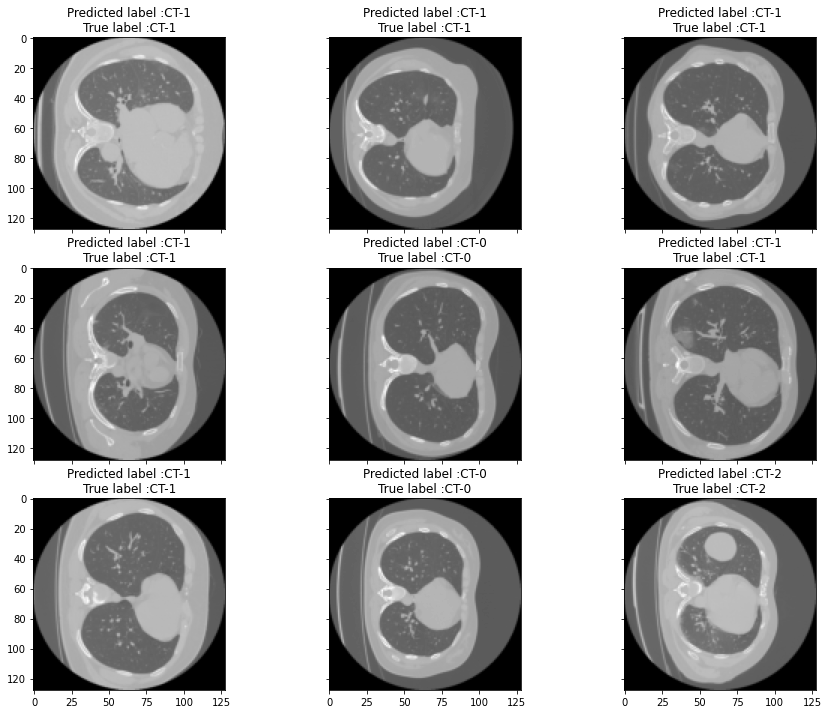

In [28]:
label= ['CT-0', 'CT-1', 'CT-2', 'CT-3', 'CT-4']
imidx = random.sample(accurateindex, k=25)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]][:,:,0], cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

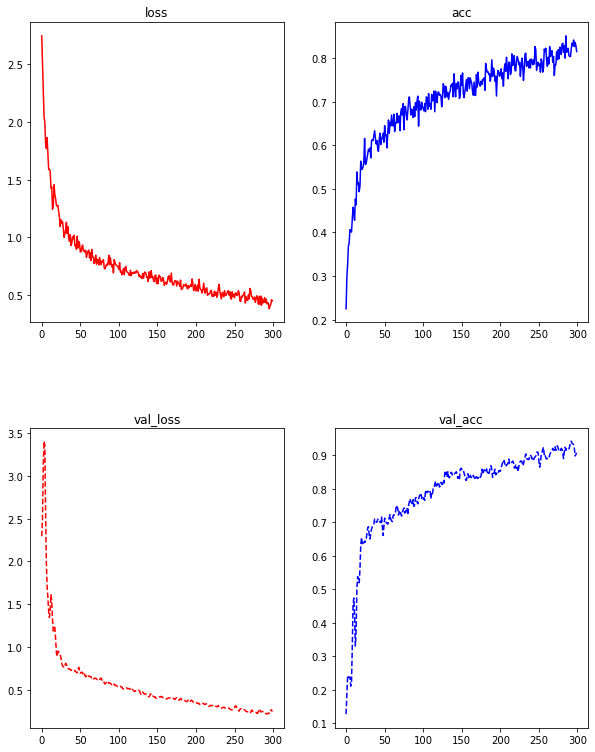

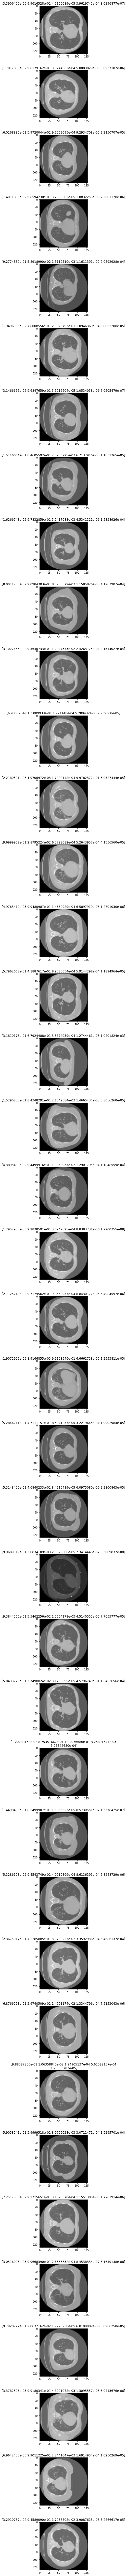

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['accuracy'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_accuracy'], 'b--')
    
preds = model.predict(xtrain)

fig1, ax1 = plt.subplots(40, 1, figsize=(10, 100))
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

for i in range(40):
    ax1[i].imshow(xtrain[i].squeeze()[:,:,0], cmap='gray')
    ax1[i].title.set_text(str(preds[i]))